The goal: fine-tune gpt2 with prefixes to discriminate between toxic and nontoxic tokens

In [1]:
from transformers import RobertaTokenizer, RobertaForTokenClassification
from transformers import BertTokenizer, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModelForCausalLM
import torch

In [5]:
import numpy as np
import pandas as pd

In [70]:
model_name = 'gpt2'
model = AutoModelForCausalLM.from_pretrained('models/gpt2-cond')
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
df1 = pd.read_csv('../data/train/train.1.tsv', sep='\t')
df0 = pd.read_csv('../data/train/train_small.0.tsv', sep='\t')
df01 = pd.concat([df1, df0], ignore_index=True)
df01.label = df01.label.astype(int)
print(df01.shape)
df01.sample(3)

(358984, 2)


,comment_text,label
352703,"Tsk,tsk. This is what happens when you:\n 1) D...",0
143960,Ignorant and greedy farmers grow food. Stop ea...,1
185136,"If you prefer, I can use sarcasm next time? Th...",0


In [7]:
add_prefix = lambda x: '{} {}'.format(' clean' if x.label == 0 else ' toxic', x.comment_text)

df01['text'] = df01.apply(add_prefix, axis=1)

In [8]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df01, test_size=0.01, random_state=1)

In [9]:
class SpansDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [10]:
MAX_LENGTH = 128

In [54]:
clf_train_dataset = SpansDataset(
    tokenizer(df_train.sample(frac=1.0).text.tolist(), truncation=True, max_length=MAX_LENGTH), 
    labels=None
)

In [32]:
clf_test_dataset = SpansDataset(
    tokenizer(df_test.text.tolist(), truncation=True, max_length=MAX_LENGTH), 
    labels=None
)

In [33]:
device = torch.device('cuda:4')
model.to(device);

In [34]:
from transformers import Trainer, TrainingArguments
from transformers.file_utils import cached_property
from typing import Tuple

class TrAr(TrainingArguments):
    @cached_property
    def _setup_devices(self) -> "torch.device":
        return device

In [71]:
training_args = TrAr(
    output_dir='./models/gpt2-cond',   # output directory
    overwrite_output_dir=True,
    num_train_epochs=3,             # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    #gradient_accumulation_steps=16,
    per_device_eval_batch_size=16,  # batch size for evaluation
    warmup_steps=5000,              # number of warmup steps for learning rate scheduler
    weight_decay=1e-9,              # strength of weight decay
    learning_rate=5e-5,
    logging_dir='./logs',           # directory for storing logs
    logging_steps=50,
    eval_steps=300,
    evaluation_strategy='steps',
    save_total_limit=2,
)

In [72]:
from transformers import DataCollatorForLanguageModeling

In [73]:
trainer = Trainer(
    model=model,                             # the instantiated 🤗 Transformers model to be trained
    args=training_args,                      # training arguments, defined above
    train_dataset=clf_train_dataset,         # training dataset
    eval_dataset=clf_test_dataset,           # evaluation dataset
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    tokenizer=tokenizer,
)

In [74]:
tokenizer.pad_token = tokenizer.eos_token

In [75]:
import gc
gc.collect()
with torch.cuda.device('cuda:4'):
    torch.cuda.empty_cache()

In [76]:
model.train();

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
300,3.685000,3.731149,14.226800,252.341000
600,3.645000,3.735057,14.223100,252.406000
900,3.571000,3.740547,14.209100,252.654000
1200,3.573300,3.746353,14.192200,252.956000
1500,3.505500,3.755964,14.212500,252.595000
1800,3.454200,3.767750,14.202100,252.779000
2100,3.346200,3.778579,14.192800,252.944000
2400,3.384200,3.783519,14.201100,252.797000
2700,3.378200,3.787323,14.224400,252.383000
3000,3.393400,3.786280,14.216200,252.529000


После одной эпохи лосс такой 3.820700	3.739524 -> ROC AUC 0.7826694435255079

Потом немножко поломал, потом ещё эпоха: 3.724600	3.729579 -> 0.7949317627038786

Ещё несколько эпох, в финале 3.52 / 3.728 -> 0.798 (на максимуме 0.7750)

Потом оказалось, что я вместо toxic пишу dirty, и после подгона токена roc auc сразу вырос до 0.855 / 0.835

In [86]:
model.save_pretrained('models/gpt2-cond')

### Evaluate as classifier

In [78]:
model.eval();

In [144]:
def get_text_toxicity(text, model=model, pos_text=' clean ', neg_text=' toxic ', raw=False):
    scores = []
    for prefix in [pos_text, neg_text]:
        x = tokenizer(prefix + text, return_tensors='pt', truncation=True)['input_ids'].to(model.device)
        with torch.no_grad():
            r = model(x, labels=x)
        scores.append(r.loss.item())
    if raw:
        return scores
    return scores[0] - scores[1]

In [145]:
print(get_text_toxicity('The internal policy of Trump is not quite adequate.'))
print(get_text_toxicity('The internal policy of Trump is not right.'))
print(get_text_toxicity('The internal policy of Trump is stupid.'))
print(get_text_toxicity('The internal policy of the fucking Trump is stupid.'))

-0.10336971282958984
-0.04397249221801758
0.3848733901977539
0.3750596046447754


In [146]:
from tqdm.auto import tqdm, trange

In [147]:
scores = []
for text in tqdm(df_test.comment_text):
    scores.append(get_text_toxicity(text))

In [148]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(df_test.label, scores))

0.8550687385341795


In [149]:
from nltk import sent_tokenize

def max_text_toxicity(text, raw=False, **kwargs):
    toxicities = [get_text_toxicity(s, **kwargs) for s in sent_tokenize(text)]
    if raw:
        return toxicities
    return max(toxicities)

In [150]:
scores = []
for text in tqdm(df_test.comment_text):
    scores.append(max_text_toxicity(text))
print(roc_auc_score(df_test.label, scores))


0.8352543281906307


### Evaluate as tagger

In [88]:
import os
import sys
import numpy as np
import pandas as pd
from ast import literal_eval
from importlib import reload

def add_sys_path(p):
    p = os.path.abspath(p)
    if p not in os.sys.path:
        sys.path.append(p)

add_sys_path('../../semeval2021')

In [89]:
path = 'data/'

In [90]:
trial = pd.read_csv(path + 'tsd_trial.csv')
train = pd.read_csv(path + 'tsd_train.csv')
final_test = pd.read_csv(path + 'tsd_test.csv')

train['spans'] = train.spans.apply(literal_eval)
trial['spans'] = trial.spans.apply(literal_eval)
trial.shape, train.shape, final_test.shape

((690, 2), (7939, 2), (2000, 1))

In [91]:
import spans_utils
reload(spans_utils)
from spans_utils import display_spans, spans2labels, labels2spans

In [110]:
n = 0
for row in tqdm([row for i, row in trial.iterrows()]):
    labels = spans2labels(row.text, row.spans, tokenizer, bos=False, left_space=False)
    spans2 = labels2spans(row.text, labels, tokenizer, space='Ġ',  bos=False, left_space=False)
    if row.spans != spans2:
        t = row.text.replace(' ', '+')
        #display_spans(row.spans, t)
        #display_spans(spans2, t)
        n += 1
        #print(row.name, n)
print(n, '/', trial.shape[0])


61 / 690


In [151]:
def get_tokens_toxicity(text, model=model, tokenizer=tokenizer, pos_text=' clean ', neg_text=' toxic ', raw=False):
    scores = []
    for prefix in [pos_text, neg_text]:
        x = tokenizer(prefix + text, return_tensors='pt')['input_ids'].to(model.device).flatten()
        with torch.no_grad():
            r = model(x)
        ce = torch.nn.functional.cross_entropy(r.logits, x, reduction='none').cpu().numpy()
        scores.append(ce)
    if raw:
        return scores
    return scores[0] - scores[1]

In [169]:
x = tokenizer(' toxic ' + text, return_tensors='pt')['input_ids'].to(model.device).flatten()
with torch.no_grad():
    r = model(x)
ce = torch.nn.functional.cross_entropy(r.logits, x, reduction='none').cpu().numpy()

tensor([[3424]])

In [190]:
model.generate(tokenizer.encode(' clean', return_tensors='pt').to(model.device))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[3424,  314, 1101,  407, 1654,  644,  345, 1612,  416,  366, 1169, 1364,
         1911,  220,  314,  892,  345, 1612,  262, 1364]], device='cuda:4')

In [211]:
print(tokenizer.decode(model.generate(
    tokenizer.encode(' clean', return_tensors='pt').to(model.device),
    do_sample=True, 
    temperature=1,
)[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 clean There will always be those in the business world that would not accept a sales tax because most Al


In [252]:
text = 'Never think you man are a bleeding stupid tall idiot.'
tt = get_tokens_toxicity(text)
tt

array([ 0.67003345,  0.3655281 , -0.19273281,  0.32772732,  0.45638418,
       -0.3000698 , -0.1049881 ,  0.67400837,  2.5905404 ,  0.8584938 ,
        1.4604149 , -0.21906662], dtype=float32)

In [253]:
len(tt)

12

In [258]:
labels = (tt>1).astype(int).tolist()[1:] + [0]
spans2 = labels2spans(text, labels, tokenizer, space='Ġ',  bos=False, left_space=False)

In [259]:
display_spans(spans2, text.replace(' ', '+'))

In [261]:
toxicities = [get_tokens_toxicity(text) for text in tqdm(trial.text)]

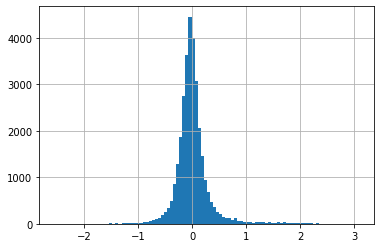

In [267]:
pd.Series([tt for t in toxicities for tt in t[1:]]).hist(bins=100);

In [269]:
from semeval2021 import f1

Результат: мы получаем чуть более высокое качество, чем рандом, но существенно ниже всех нормальных бейзлайнов: 22% вместо 70%. 

In [278]:
for threshold in [-2, -1, -0.5, 0, 0.25, 0.3, 0.4, 0.45, 0.5, 0.75, 1, 2]:
    preds = []
    for text, tt in zip(trial.text, toxicities):
        labels = (tt>threshold).astype(int).tolist()[1:] + [0]
        preds.append(labels2spans(text, labels, tokenizer))
    print(threshold, '\t', np.mean([f1(p, y) for p, y in zip(preds, trial.spans)]))

-2 	 0.19312386083147567
-1 	 0.1922833064435526
-0.5 	 0.1917400004375064
0 	 0.18883939442793682
0.25 	 0.2130155080781475
0.3 	 0.21697875359144275
0.4 	 0.2183846590943954
0.45 	 0.22148712444404112
0.5 	 0.21827046418759644
0.75 	 0.20960342261525283
1 	 0.19962231627375884
2 	 0.0887408311526229


In [277]:
def display_token_score(spans, text):
    # todo: use style="background-color: #Oxffffff"
    result = []
    spans = set(spans)
    toxic, prev_toxic = False, False
    for i, c in enumerate(text):
        if i in spans:
            toxic = True
            if not prev_toxic:
                result.append('<b>')
        else:
            toxic = False
            if prev_toxic:
                result.append('</b>')
        result.append(c)
        prev_toxic = toxic
    try:
        display(HTML(''.join(result)))
    except InvalidURL:
        print(''.join(result))

In [286]:
len(tokenizer.tokenize(text))

80

In [287]:
len(tt[1:].tolist())

80

In [342]:
from IPython.core.display import display, HTML
import matplotlib


def display_token_scores(tokens, scores, b=None, cmap=None):
    if cmap is None:
        cmap = matplotlib.cm.get_cmap('bwr')
    if b is None:
        b = [0] * len(tokens)

    spans  = []
    for token, score, boldness in zip(tokens, scores, b):
        text = token.replace("Ġ", " ")
        if boldness:
            text = '<b>{}</b>'.format(text)
        spans.append(
            '<span style="background-color: {}">{}</span>'.format(
                "#{0:02x}{1:02x}{2:02x}".format(*cmap(score, bytes=True)[:3]),
                text
            )
        )

    display(HTML(''.join(spans)))

In [397]:
row = trial.sample(1).iloc[0]
text = row.text
tt = get_tokens_toxicity(text)

tokens = tokenizer.tokenize(text)
scores = (1 / (1 + np.exp(-tt[1:]))).tolist()
gt_spans = spans2labels(text=text, spans=row.spans, tokenizer=tokenizer)[1:]

display_token_scores(tokens, scores, b=gt_spans)

In [414]:
for i in range(3):
    row = trial.sample(1).iloc[0]
    text = row.text
    tt = get_tokens_toxicity(text)

    tokens = tokenizer.tokenize(text)
    scores = (1 / (1 + np.exp(-tt[1:]))).tolist()
    gt_spans = spans2labels(text=text, spans=row.spans, tokenizer=tokenizer)[1:]

    display_token_scores(tokens, scores, b=gt_spans)